In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import fantasyfootball
from os import path
from fantasyfootball.config import DATA_DIR, pfr_to_fantpros, nfl_color_map, nfl_logo_espn_path_map
import seaborn as sns
import numpy as np

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
YEAR = 2020
df = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/' \
                         'play_by_play_' + str(YEAR) + '.csv.gz?raw=True',
                         compression='gzip', low_memory=False)

In [6]:
df.describe()

,play_id,old_game_id,week,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,drive,sp,qtr,down,goal_to_go,ydstogo,ydsnet,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,air_yards,yards_after_catch,kick_distance,home_timeouts_remaining,away_timeouts_remaining,timeout,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,lateral_rusher_player_id,lateral_rusher_player_name,lateral_sack_player_id,lateral_sack_player_name,lateral_interception_player_id,lateral_interception_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackle_4_team,fumble_recovery_1_yards,fumble_recovery_2_yards,return_yards,penalty_yards,replay_or_challenge,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,season,cp,cpoe,series,series_success,order_sequence,play_clock,play_deleted,special_teams_play,fixed_drive,drive_real_start_time,drive_play_count,drive_first_downs,drive_inside20,drive_ended_with_score,drive_quarter_start,drive_quarter_end,drive_yards_penalized,drive_play_id_started,drive_play_id_ended,away_score,home_score,result,total,spread_line,total_line,div_game,surface,temp,wind,success,passer_jersey_number,rusher_jersey_number,receiver_jersey_number,pass,rush,first_down,aborted_play,special,play,jersey_number,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd
count,11472.000000,1.147200e+04,11472.000000,10495.000000,11470.000000,11470.000000,11470.000000,11472.000000,11407.000000,11472.000000,11472.000000,9421.000000,11472.000000,11472.000000,11346.000000,10963.000000,11472.000000,11472.000000,10963.000000,11472.000000,11472.000000,11472.000000,4466.000000,2981.000000,1126.000000,11472.000000,11472.000000,10963.000000,10491.000000,10491.000000,11472.000000,11472.000000,10491.000000,10491.000000,10491.000000,10491.000000,10491.000000,10491.000000,11472.000000,11472.000000,11472.000000,11472.000000,11472.000000,11472.0000

In [29]:
my_cols = ['receiver', 'posteam', 'play_type', 'air_yards']
play_type = df['play_type'] == 'pass'

In [31]:
pass_df = df.loc[play_type, my_cols]

In [70]:
pass_df = pass_df.replace({'posteam' : {'LA': 'LAR'}})

In [60]:
def target_share_vs_air_yard_share(df):
    my_cols = ['receiver', 'posteam', 'play_type', 'air_yards']
    play_type = df['play_type'] == 'pass'
    df =  df.loc[play_type, my_cols].copy()
    df = (df.groupby(['receiver', 'posteam'])
            .agg(targets=('play_type', 'count'), air_yards=('air_yards', 'sum'))
            .sort_values('targets', ascending=False)
            .reset_index()
             )
    df = (df.assign(team_targets=df.groupby('posteam')['targets'].transform('sum'))
           .assign(team_air_yards=df.groupby('posteam')['air_yards'].transform('sum'))
         )
    df = (df.assign(target_share=df['targets'] / df['team_targets'])
            .assign(air_yard_share= df['air_yards'] / df['team_air_yards'])
         )
    return df
    

In [71]:
graph_df = target_share_vs_air_yard_share(pass_df)

In [72]:
graph_df = graph_df.sort_values('targets', ascending=False).head(60)

In [73]:
graph_df

,receiver,posteam,targets,air_yards,team_targets,team_air_yards,target_share,air_yard_share
0,A.Cooper,DAL,51,476.0,200,1552.0,0.255000,0.306701
1,K.Allen,LAC,50,422.0,133,1091.0,0.375940,0.386801
2,D.Hopkins,ARI,46,312.0,136,1038.0,0.338235,0.300578
4,A.Robinson,CHI,41,472.0,156,1493.0,0.262821,0.316142
3,C.Ridley,ATL,41,658.0,167,1631.0,0.245509,0.403433
5,D.Waller,LV,40,228.0,138,919.0,0.289855,0.248096
6,T.McLaurin,WAS,39,397.0,144,973.0,0.270833,0.408016
7,A.Kamara,NO,35,33.0,127,729.0,0.275591,0.045267
8,S.Diggs,BUF,35,386.0,144,1113.0,0.243056,0.346810
9,R.Anderson,CAR,35,310.0,138,941.0,0.253623,0.329437


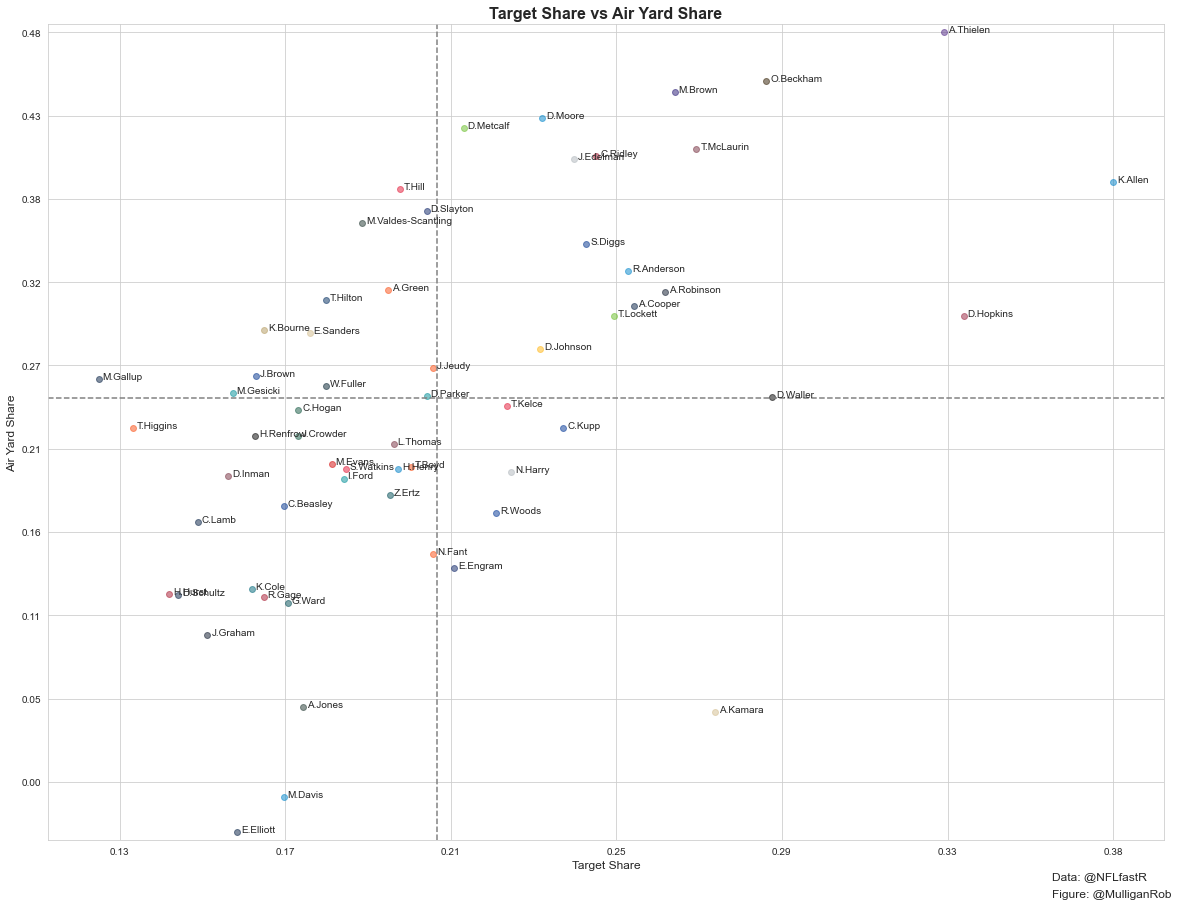

In [105]:
sns.set_style('whitegrid');
fig, ax = plt.subplots(figsize=(20, 15))
for ix, row in graph_df.iterrows():
    ax.scatter(row['target_share'], row['air_yard_share'], color=nfl_color_map[row['posteam']], alpha=0.5)
    ax.annotate(row['receiver'], xy=(row['target_share']+.001, row['air_yard_share']), alpha=1.0, zorder=2)
ax.set_xlabel('Target Share', fontsize=12)
ax.set_ylabel('Air Yard Share', fontsize=12)

avg_target_share = graph_df['target_share'].mean()
avg_air_yard = graph_df['air_yard_share'].mean()  
ax.axvline(avg_target_share, linestyle='--', color='gray')
ax.axhline(avg_air_yard, linestyle='--', color='gray')
ax.set_title('Target Share vs Air Yard Share', fontsize=16, fontweight='bold')
ax.set_xticks(np.linspace(0, graph_df['target_share'].max(), 10))
xlabels = ["{0:.2f}".format(x) for x in np.linspace(0, graph_df['target_share'].max(), 10)]
ax.set_xticklabels(xlabels)
ax.set_yticks(np.linspace(0, graph_df['air_yard_share'].max(), 10))
ylabels = ["{0:.2f}".format(x) for x in np.linspace(0, graph_df['air_yard_share'].max(), 10)]
ax.set_yticklabels(ylabels)
ax.margins(x=.05, y=.01)
ax.annotate('Data: @NFLfastR',xy=(.90,-0.05), fontsize=12, xycoords='axes fraction')
ax.annotate('Figure: @MulliganRob',xy=(.90,-0.07), fontsize=12, xycoords='axes fraction');